In [1]:
# We install the prerequisites using the `!pip install` syntax here.
# In some cases, running pip install from a notebook may require a one-time kernel restart. Check the output for messages.
!pip install --user cloudant==2.10.2 --quiet
!pip install --user bokeh==0.12.10 --quiet
!pip install --user seaborn==0.9.0 --quiet
#!pip install --user sc2reader==1.3.1 # sc2reader==1.3.1 only works for replay version 44401
!pip install --user git+https://github.com/ggtracker/sc2reader.git --quiet # the old sc2reader is dead. This is the up-to-date fork

In [24]:
import sys, importlib
sys.path.append("../")
from util.event_parser import *
from util.replay_data import *
from util.visualization import *
import pandas as pd
from collections import defaultdict
from traceback import print_exc

from bokeh.io import output_notebook, reset_output
from bokeh.models import Span, Range1d, Legend, BoxAnnotation, HoverTool, Arrow, NormalHead
from bokeh.plotting import figure, show, gridplot, ColumnDataSource

%load_ext autoreload
%autoreload 2

output_notebook()

# Some extra code here helps catch setup errors.
try:
    #replay_file = "king_sejong_station_le.sc2replay"
    replay_file = "replay/Lower Final/Serral VS Trap LB Final - Game 1.SC2Replay"
except NameError:
    print('\n'
          'SETUP ERROR: Please follow the directions to add a .SC2Replay file and use\n'
          '             "Insert to code" to set the streaming_body_1 variable to the resulting bytes.\n'
          '             You may need to rename the data_* variable.')
    raise

replay = sc2reader.load_replay(
    replay_file,
    engine=sc2reader.engine.GameEngine(plugins=[ContextLoader(), APMTracker(), SelectionTracker()]))

print("Replay successfully loaded.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/user/SC_Replay_mining/util/visualization.py:217: SyntaxWarning: "is" with a literal. Did you mean "=="?
  right=timeseries[rng[1]] / 16,
/home/user/SC_Replay_mining/util/visualization.py:224: SyntaxWarning: "is" with a literal. Did you mean "=="?
  right=timeseries[rng[1]] / 16,
/home/user/SC_Replay_mining/util/visualization.py:235: SyntaxWarning: "is" with a literal. Did you mean "=="?
  y_start=src[rng[0]],
/home/user/SC_Replay_mining/util/visualization.py:246: SyntaxWarning: "is" with a literal. Did you mean "=="?
  y_start=src[rng[0]],


Loading BokehJS ...

Replay successfully loaded.


In [3]:
print("Date: %s" % replay.date)
print("Map Name: " + replay.map_name)
for player in replay.players:
    print("%s: %s" % (player.result, player))

Date: 2021-12-12 15:27:26
Map Name: Berlingrad LE
Win: Player 1 - Serral (Zerg)
Loss: Player 2 - Trap (Protoss)


In [18]:
replay_object = ReplayData.parse_replay(replay=replay)
replay_dict = replay_object.as_dict()

players = {}
for player in replay_dict["winners"]:
    players[int(player[0])] = {"full": "Winning Player {num}: {name} ({race})".format(num=player[0], name=player[1], race=player[2]),
                               "short": "{name} ({race})".format(name=player[1], race=player[2]) }
for player in replay_dict["losers"]:
    players[int(player[0])] = {"full": "Losing Player {num}: {name} ({race})".format(num=player[0], name=player[1], race=player[2]),
                               "short": "{name} ({race})".format(name=player[1], race=player[2]) }

econ = ["mineral_collection_rate", "vespene_collection_rate", "workers_active", "supply_utilization", "worker_supply_ratio"]
units = ["Minerals per Minute (MPM)", "Vespene per Minute (VPM)", "Workers", "Supply Used / Supply Available", "Workers / Supply Used"]

player_charts = defaultdict(dict)
player_aggregate = defaultdict(dict)

In [25]:
for pid, player in players.items():
    for ndx, process in enumerate(econ):
        # Generate charts per player
        timeseries = [k[0] for k in replay_dict["stats"][pid][process]]
        proc_data = [j[1] for j in replay_dict["stats"][pid][process]]

        player_charts[pid][process], limits, v_min, v_max, game_length = nelson_rules_chart_generator(
            pd.Series(proc_data),
            timeseries,
            player["full"],
            pid,
            process,
            units[ndx],
            replay,
            fixed_lcl=0)
        player_aggregate[process][pid] = proc_data

grid = [[player_charts[k][measurement] for k in player_charts] for ndx, measurement in enumerate(econ)]

show(gridplot(grid, sizing_mode="scale_width"))

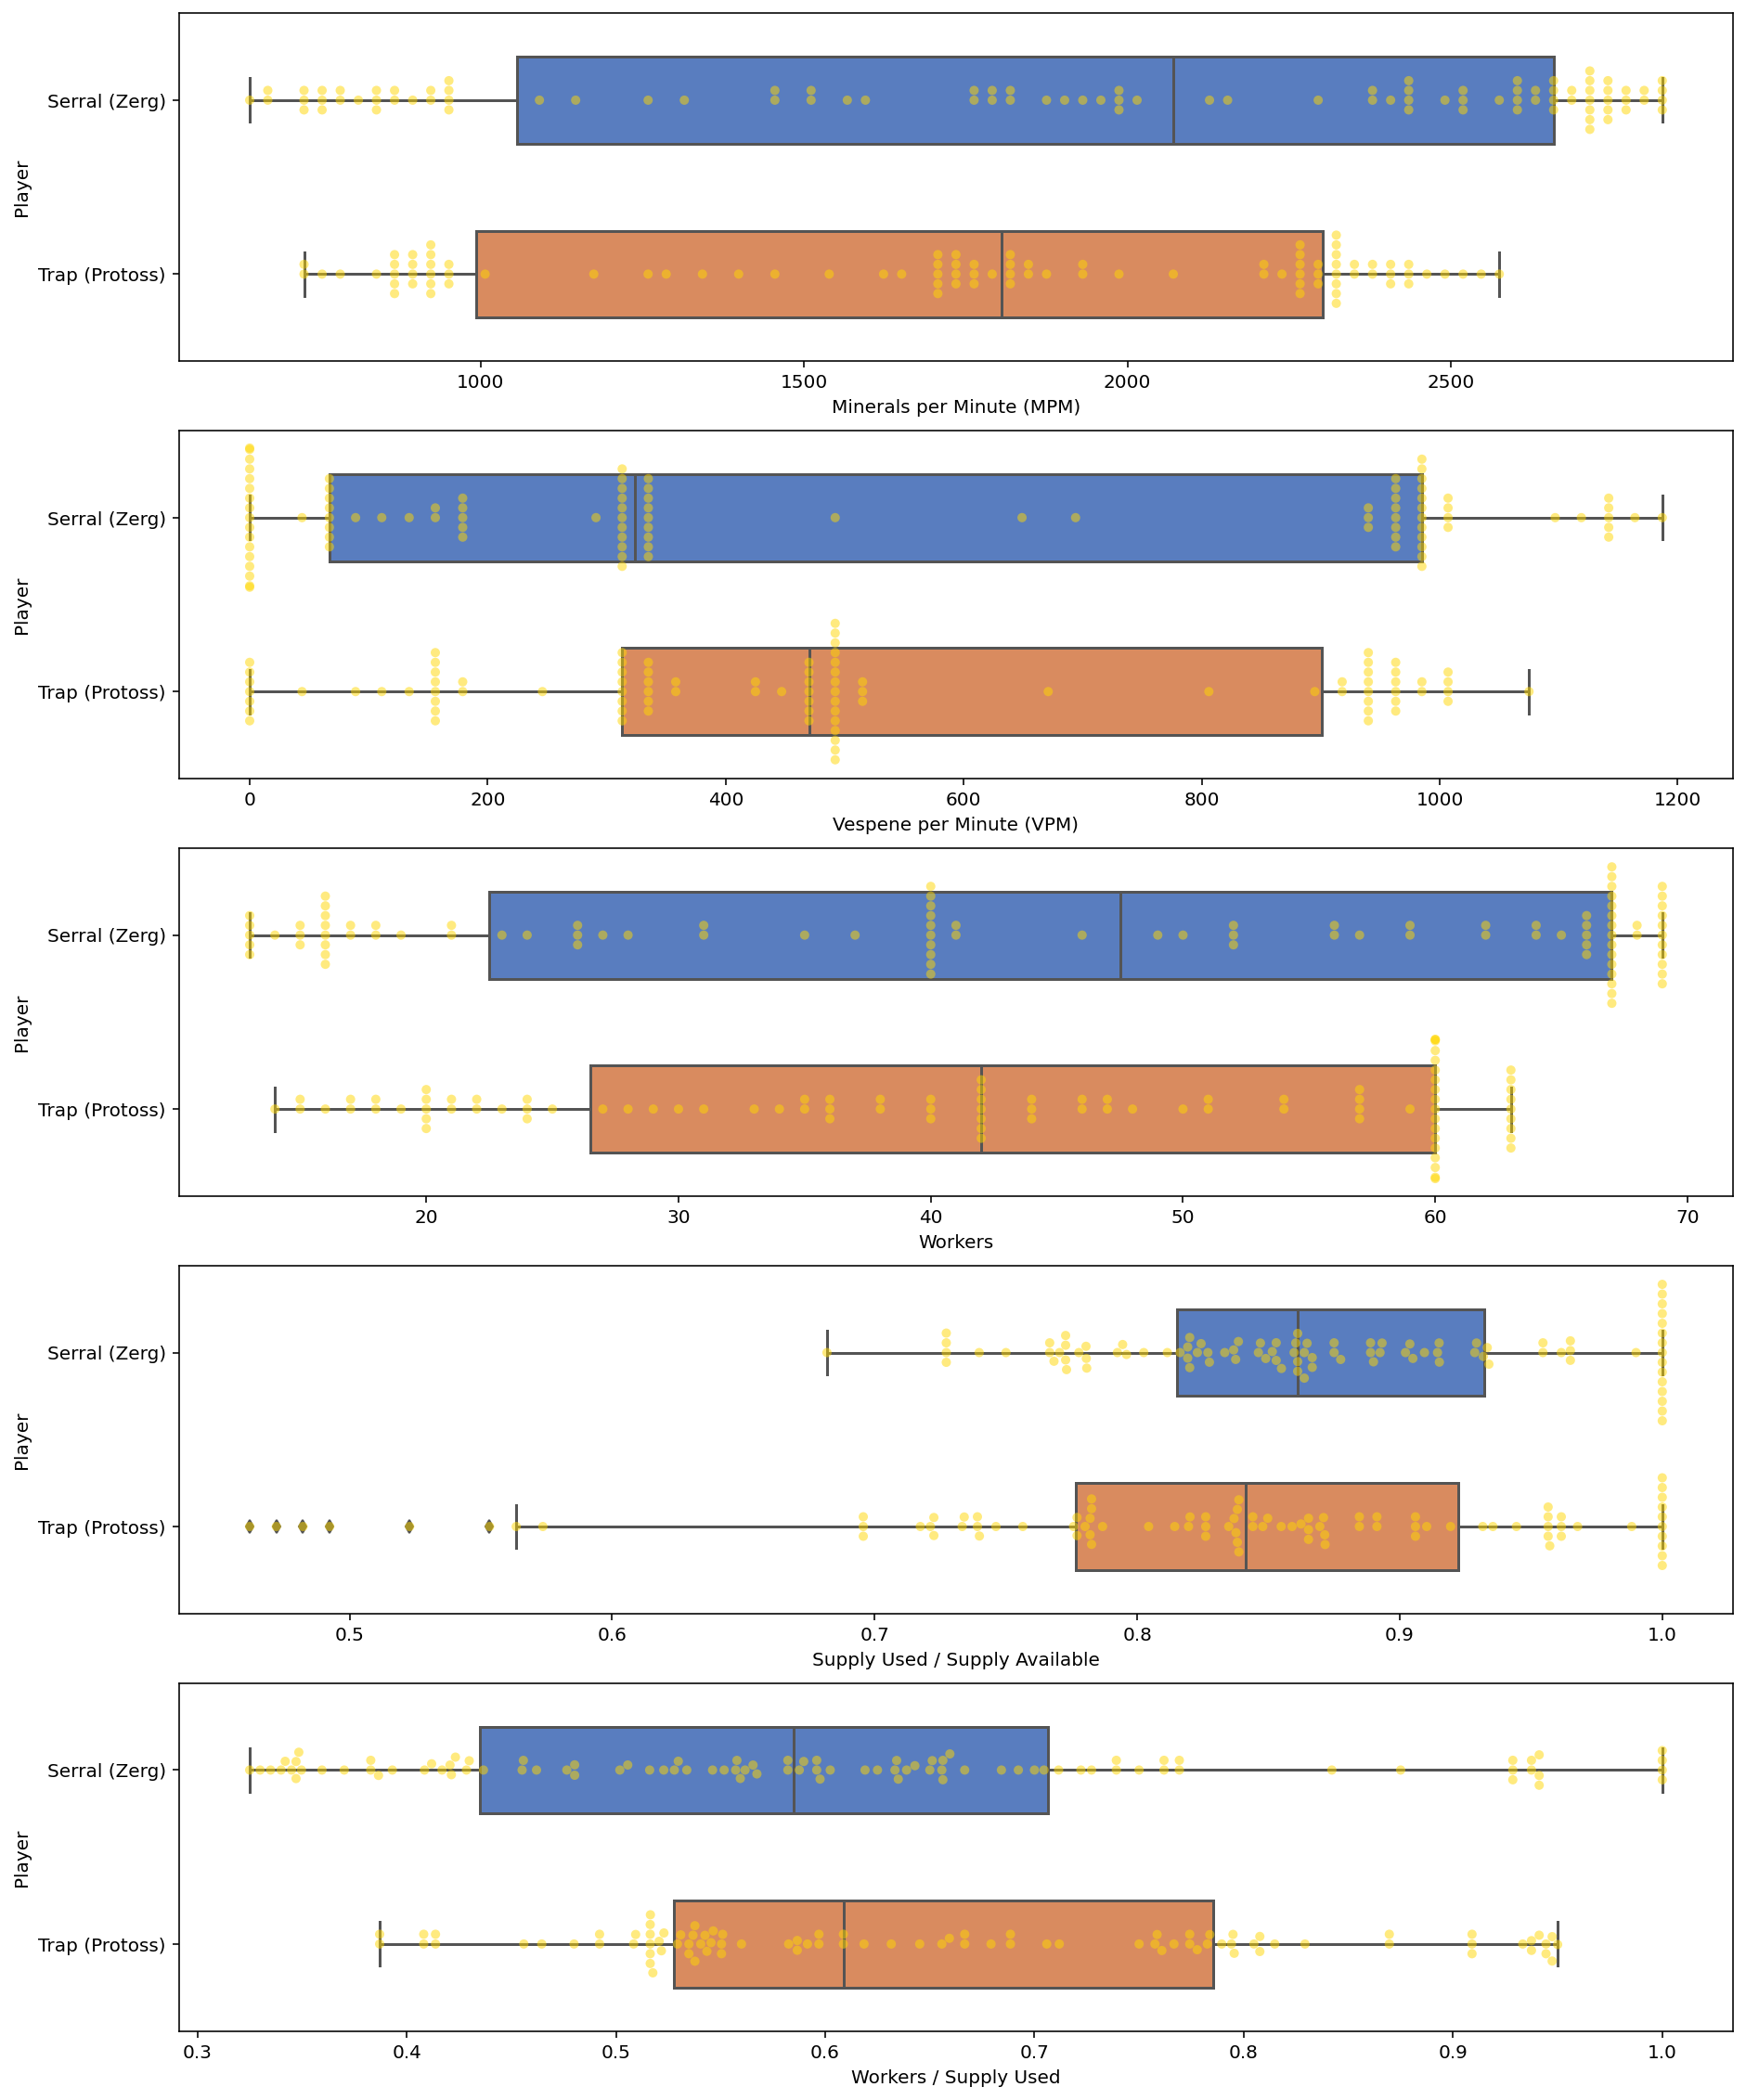

In [26]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=len(grid),ncols=1,figsize=(15,20))

for ndx in range(len(grid)):

    sample_max = min([len(player_aggregate[econ[ndx]][j]) for j in player_aggregate[econ[ndx]].keys()])
    # Remember, we are removing the first 20 samples (beginning of game should be the same for all, so data is useless)
    frame = pd.DataFrame({ units[ndx]: [player_aggregate[econ[ndx]][1][k] for k in range(2,sample_max)] + [player_aggregate[econ[ndx]][2][l] for l in range(2,sample_max)],
                           "Player": [players[(i//sample_max) + 1]["short"] for i in range(0,len(players.keys())*(sample_max - 2))]})
    
    bp = seaborn.boxplot(x=units[ndx], orient="h", y='Player',  data=frame,  width=0.5, palette="muted", ax=axes[ndx])
    bp = seaborn.swarmplot(x=units[ndx], y='Player', data=frame,  color='gold', alpha=0.5, ax=axes[ndx])

plt.show()